In [16]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [17]:
DATASET_PATH = "images\\"
METADATA_PATH = "metadata_win1.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id1.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 115
EPOCHS = 25
TESTING_SIZE = 100
VALIDATION_SPLIT = 0.01
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [18]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-18-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,pear\28041582351_a5c98871bc_o.jpg,[pear]
1,ramen\3402528.jpg,[ramen]
2,rambutan\3875401171_0c4bb25d26_o.jpg,[rambutan]
3,Chicken_and_Waffles\Image_481.jpg,[chicken_and_waffles]
4,Grilled_Cheese\Image_480.jpg,[grilled_cheese]
...,...,...
406407,Oyakodon\Image_395.jpg,[oyakodon]
406408,hummus\3065799.jpg,[hummus]
406409,creme_brulee\Image_195..jpg,[creme_brulee]
406410,haupia\pic218044.jpg,[haupia]


In [19]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [20]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 402348 validated image filenames belonging to 755 classes.
Found 4064 validated image filenames belonging to 755 classes.


In [21]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        #model.add(Dense(256, activation='relu'))
        model.add(Dense(len(unique_labels), activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [22]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

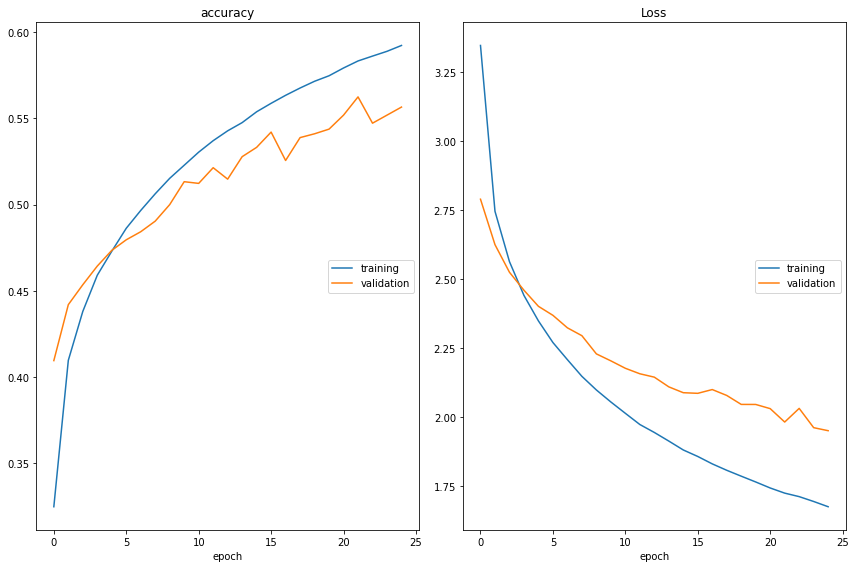

accuracy
	training         	 (min:    0.325, max:    0.592, cur:    0.592)
	validation       	 (min:    0.409, max:    0.562, cur:    0.557)
Loss
	training         	 (min:    1.675, max:    3.346, cur:    1.675)
	validation       	 (min:    1.950, max:    2.789, cur:    1.950)

Epoch 00025: val_accuracy did not improve from 0.56250


In [23]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [24]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 100 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


100/100 [==============================] - 2s 15ms/step


In [25]:
for prediction in predictions:
    print(prediction)

[3.92165589e-08 2.16742266e-11 7.41491490e-09 7.20014215e-10
 1.00580010e-07 4.40545739e-10 3.56119330e-04 4.74331891e-13
 2.62730175e-08 8.92869480e-07 4.82985065e-08 5.32654347e-08
 6.90611444e-08 3.41882185e-07 8.52495248e-08 4.38904841e-08
 1.14709815e-08 2.36736640e-04 1.59108149e-05 3.56423425e-06
 6.53414600e-06 9.16774127e-07 5.68025129e-08 4.59976857e-09
 2.88778847e-05 3.97964577e-08 9.31497990e-09 9.02219142e-07
 9.57782618e-08 1.94990607e-05 1.49646849e-05 1.32119763e-04
 4.69827377e-08 4.45294972e-07 2.55758619e-06 2.45606225e-06
 3.40987867e-06 4.63241122e-07 6.85004807e-07 1.13630927e-06
 5.00263695e-06 1.03550190e-06 1.54608202e-08 1.64232533e-05
 3.60503249e-09 5.67960923e-09 4.73687034e-10 4.48658035e-08
 2.87212202e-07 6.16796001e-08 1.22310295e-08 3.50125561e-07
 3.09109822e-08 7.13900217e-10 2.04715207e-06 1.81649917e-10
 1.02709660e-10 2.32079583e-06 3.74364317e-04 4.14461101e-06
 2.09709924e-07 4.76594579e-07 9.00103192e-09 3.24400162e-07
 1.67701856e-07 1.742831

[1.52102009e-09 3.01578993e-13 6.80137424e-13 3.37880180e-12
 4.13010026e-09 3.74463264e-12 1.04491289e-06 1.77511437e-17
 1.00036861e-14 1.46302276e-11 2.26434590e-14 4.71268684e-12
 1.96330028e-08 1.84265339e-10 1.38299207e-11 1.55862018e-13
 2.41166098e-15 7.70327205e-11 5.10532394e-10 1.20607115e-06
 1.20026051e-08 1.03132184e-12 2.95834897e-14 1.22101114e-13
 6.72751144e-09 4.02495537e-10 7.19197132e-11 4.39854438e-11
 3.19441557e-10 3.53700021e-11 6.62642421e-08 6.32576935e-10
 4.67184243e-11 3.21055538e-09 4.87268670e-10 5.51579282e-10
 9.33844788e-08 2.23371650e-08 5.89348037e-09 1.22234937e-12
 3.18910703e-10 1.09278541e-11 1.85711601e-14 4.21493462e-09
 1.32219178e-08 3.90059377e-13 4.52420089e-12 2.79964962e-13
 8.15647116e-12 1.14975989e-11 2.03034714e-10 4.58532036e-14
 7.55634433e-13 1.67642823e-13 2.39560394e-09 1.25911134e-14
 2.37506895e-15 7.00412298e-11 8.95483510e-08 3.00210257e-09
 2.34144335e-14 1.81828320e-11 1.40269014e-08 2.00760599e-08
 1.33058391e-11 9.728152

[1.26377131e-06 6.61772310e-06 2.61025349e-07 3.08597984e-04
 3.15072939e-05 3.09135852e-04 5.73618418e-05 3.66249496e-11
 6.40392227e-06 1.11527052e-05 5.85750058e-06 1.10078654e-05
 2.35219413e-04 3.05413814e-05 8.23988012e-06 4.06646977e-05
 1.36015742e-05 1.89817522e-03 7.03577462e-06 3.67745612e-04
 8.17428809e-05 9.53890412e-06 1.10908528e-04 1.10808833e-06
 1.88667880e-04 2.35989887e-06 1.05028275e-05 2.49680132e-04
 1.19500828e-03 1.07838530e-02 1.10074151e-02 4.35054273e-04
 4.25800541e-03 2.15050299e-03 1.13727786e-02 3.08378227e-03
 5.12616262e-02 1.62938191e-03 2.58640684e-02 3.87531309e-03
 9.96094756e-03 2.96741811e-04 6.92083813e-06 7.75245269e-07
 8.48800141e-08 9.11909410e-07 2.44965781e-06 6.03639592e-07
 1.06326324e-05 1.93167239e-06 5.54860264e-07 5.17980197e-06
 4.07554689e-05 1.48175486e-05 2.06347113e-03 5.59302805e-07
 1.38832338e-05 1.77358306e-04 2.03884277e-03 9.79413395e-04
 3.48293874e-03 9.68314907e-07 1.11353031e-04 6.82802056e-04
 2.35635467e-04 5.399534

 2.30042716e-07 6.69355273e-08 2.18710302e-05]
[7.60764607e-08 6.95417508e-12 1.25998812e-11 1.38800596e-14
 1.80178339e-09 9.65932317e-15 9.02234731e-09 1.03431271e-19
 3.76641079e-11 5.47672801e-12 2.95429972e-15 3.71949677e-13
 4.66382835e-12 5.19310547e-14 2.97264480e-09 3.97133999e-06
 5.12953341e-13 5.83876046e-12 3.53914150e-14 2.26257121e-11
 1.56899382e-10 2.13634610e-10 2.94319745e-15 8.62956841e-13
 7.61966157e-10 5.76623100e-14 1.72661989e-11 8.20178832e-13
 3.39988558e-11 1.06501755e-13 1.38348309e-11 4.30835136e-13
 2.44541637e-10 1.32128761e-11 5.57513867e-15 3.03753578e-10
 5.40382669e-11 4.40795566e-13 1.98849617e-10 2.09202057e-12
 8.63805381e-12 4.88989491e-13 5.32876410e-10 5.68710226e-12
 2.92518543e-09 8.97602825e-11 1.69989229e-16 2.57862373e-12
 1.54373273e-13 2.68250943e-13 4.42979339e-13 4.56175354e-13
 3.52053456e-13 1.50644937e-12 6.07659485e-13 4.64269595e-12
 5.04309811e-16 2.00677149e-12 4.38698766e-09 3.52858151e-13
 8.09980902e-12 1.00041997e-11 3.05405

 2.61527380e-11 3.82263578e-12 3.57398631e-06]
[1.64604990e-05 6.16171469e-09 7.08948392e-06 5.54378028e-04
 3.67870553e-06 6.10588017e-07 1.26699194e-01 2.28747563e-10
 5.55913663e-04 1.38945938e-06 7.68311395e-07 2.43267255e-08
 4.92691606e-06 5.85100061e-05 1.88246358e-05 1.33052499e-05
 1.76966365e-04 2.47699721e-03 2.10179016e-03 1.33131063e-04
 6.73531758e-06 8.46426337e-06 1.75118018e-07 4.22750446e-07
 1.51359998e-02 2.28118643e-06 1.71134525e-05 4.74424178e-06
 2.93144603e-06 9.56464919e-06 2.72324451e-05 1.17740399e-06
 5.34079049e-07 7.93068466e-05 1.20096418e-04 1.87124278e-05
 2.73757651e-05 4.05979972e-06 2.97052725e-06 4.28643887e-07
 3.19431535e-07 3.49297392e-04 8.07810750e-07 2.56847241e-04
 3.00356731e-07 4.49612713e-07 7.22166988e-06 6.19548416e-07
 8.34918410e-08 7.55083456e-04 2.13029193e-06 6.71052973e-08
 2.22489106e-07 8.04481829e-07 1.80876334e-04 1.33440642e-06
 2.08468318e-05 1.35585156e-04 2.29083925e-01 8.30844840e-07
 5.32011791e-06 1.50902076e-06 2.07705

[1.86697144e-10 6.51430437e-11 3.42042341e-08 2.91338020e-09
 8.96282604e-09 2.54809257e-10 5.77323398e-08 2.20690369e-13
 6.86160850e-10 1.65739256e-10 1.07149525e-08 1.00960298e-08
 9.94339425e-05 6.00742289e-10 2.73347352e-11 1.44116481e-11
 3.18415745e-11 2.40390641e-09 1.96128536e-09 1.76436700e-07
 4.49335516e-07 3.98057845e-12 1.41841497e-12 1.95303468e-10
 1.08311447e-07 6.59980878e-06 9.67947805e-11 3.57379709e-10
 1.15722418e-08 4.39866774e-08 1.06056834e-08 8.92750429e-10
 8.61936245e-10 2.67363992e-10 1.70368719e-11 1.25709633e-07
 8.08340839e-10 5.17189402e-09 1.14022658e-08 6.59482495e-08
 1.02753432e-08 3.74012432e-10 2.77466015e-08 1.31192019e-11
 2.77084670e-12 2.26911448e-10 3.09358494e-09 4.32282474e-11
 9.27447346e-08 5.04580058e-12 3.30030491e-12 6.19597085e-09
 4.59785023e-11 2.56708682e-11 5.39174607e-08 7.95911892e-10
 2.87560559e-10 5.97120732e-07 3.67332068e-05 2.19019785e-05
 2.39492506e-11 5.45215262e-11 3.56046221e-04 1.35842449e-04
 2.98053537e-09 5.666917

[8.22647940e-04 2.12186842e-06 2.02691772e-05 2.41133239e-05
 5.31897922e-06 1.08022249e-08 5.25383931e-03 4.19393956e-07
 1.21080076e-04 1.24330484e-06 6.20958247e-07 1.25819088e-08
 2.72170473e-06 2.35739535e-07 7.01346071e-05 1.30696906e-04
 2.40834470e-05 3.66965309e-03 1.65870995e-06 5.77974934e-05
 4.68050530e-06 1.96312722e-05 1.28319925e-05 2.25047575e-06
 5.33165352e-04 2.00204022e-06 4.87696127e-07 1.58182724e-04
 1.10472101e-04 4.17082992e-05 4.88367732e-07 2.05001470e-05
 5.15020062e-08 1.89077145e-05 1.06776033e-05 9.27105589e-07
 1.22077199e-06 1.57045594e-08 6.15643160e-07 5.72628096e-06
 3.26333549e-07 2.19215599e-05 5.28775090e-05 3.00356449e-04
 2.64595641e-04 9.82197980e-06 1.92298142e-08 1.64242908e-06
 3.03465145e-04 1.04427291e-03 2.88700016e-04 2.25897566e-06
 7.29863359e-07 6.52622248e-06 4.31628199e-04 9.67392862e-06
 2.63886000e-06 2.31020385e-03 1.22869410e-01 4.41972270e-06
 6.76227210e-05 7.17297080e-05 1.42961244e-06 5.86237729e-06
 1.68891293e-05 1.573037

[8.90794730e-12 1.21060245e-10 1.92659257e-12 1.51198932e-12
 2.47320808e-09 1.77462090e-11 1.92948710e-06 8.57787950e-18
 1.14741387e-13 2.09867280e-12 1.79206151e-13 1.85702183e-11
 2.72599321e-09 2.39304253e-11 4.07297807e-11 5.90929345e-12
 1.29599605e-13 6.40796971e-09 2.60685056e-07 1.24153217e-07
 2.82423507e-08 1.02533364e-11 4.32949787e-11 1.64940991e-10
 2.38490365e-08 5.59518876e-09 3.37601364e-10 5.84775828e-09
 1.29849032e-09 6.35717701e-10 3.01436071e-10 2.63216782e-10
 1.25415400e-10 1.72451065e-09 2.23391167e-11 1.07631327e-10
 8.49867047e-06 6.43137525e-07 1.90375782e-09 6.75209264e-11
 3.83232418e-10 6.78395118e-11 5.58315824e-11 9.65727403e-14
 1.41991414e-08 7.97290272e-12 5.81434803e-13 3.13797877e-11
 7.95332245e-09 1.83259730e-09 1.33821795e-12 5.75213792e-12
 1.14806027e-12 1.28011631e-12 1.76155812e-09 2.89742405e-13
 8.70067744e-13 8.15116366e-08 2.71577221e-07 1.56303726e-09
 1.06793680e-11 1.23841718e-11 2.93186897e-09 2.22687024e-08
 9.37723410e-14 3.830223